In [17]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip

--2025-07-26 22:23:22--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2025-07-26 22:23:22--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-07-26 22:23:22--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.116.10
Connecting to codeload.github.com (codeload.github.com)|140.82.116.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.2’

master.zip.2            [ 

In [10]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import librosa

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

def extract_yamnet_embedding(waveform, sr=16000):
    waveform = librosa.resample(waveform, orig_sr=sr, target_sr=16000)
    waveform = waveform[:16000 * 5]
    waveform = waveform.astype(np.float32)

    scores, embeddings, spectrogram = yamnet_model(waveform)

    return tf.reduce_mean(embeddings, axis=0).numpy()

In [11]:
import pandas as pd
import os

ESC50_PATH = 'ESC-50-master'
CSV_PATH = os.path.join(ESC50_PATH, 'meta', 'esc50.csv')
AUDIO_PATH = os.path.join(ESC50_PATH, 'audio')

df = pd.read_csv(CSV_PATH)

train_df = df[df['fold'] != 5]
test_df  = df[df['fold'] == 5]

file_paths_train = [os.path.join(AUDIO_PATH, fname) for fname in train_df['filename']]
class_ids_train = train_df['target'].tolist()

file_paths_test = [os.path.join(AUDIO_PATH, fname) for fname in test_df['filename']]
class_ids_test = test_df['target'].tolist()

In [12]:
import os
from tqdm import tqdm

X = []
y = []

for file_path, label in tqdm(zip(file_paths_train, class_ids_train)):
    waveform, sr = librosa.load(file_path, sr=None)
    embedding = extract_yamnet_embedding(waveform, sr)
    X.append(embedding)
    y.append(label)

X = np.array(X)
y = np.array(y)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

1600it [00:13, 119.98it/s]


In [13]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(50, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32)

Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1195 - loss: 3.9179 - val_accuracy: 0.5875 - val_loss: 2.4840
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4282 - loss: 2.5037 - val_accuracy: 0.6219 - val_loss: 1.5092
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5789 - loss: 1.7218 - val_accuracy: 0.6750 - val_loss: 1.2507
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6069 - loss: 1.5396 - val_accuracy: 0.7156 - val_loss: 1.1526
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6430 - loss: 1.4381 - val_accuracy: 0.7250 - val_loss: 1.0652
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6665 - loss: 1.2996 - val_accuracy: 0.7281 - val_loss: 1.0095
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6876 - loss: 1.2199 - val_accuracy: 0.7531 - val_loss: 0.9902
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7050 - loss: 1.0920 - val_accuracy: 0.7375 - 

In [14]:
from tqdm import tqdm
import librosa
import numpy as np

X_test = []
y_test = []

for file_path, label in tqdm(zip(file_paths_test, class_ids_test), total=len(file_paths_test)):
    waveform, sr = librosa.load(file_path, sr=None)
    embedding = extract_yamnet_embedding(waveform, sr)
    X_test.append(embedding)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 400/400 [00:03<00:00, 133.18it/s]


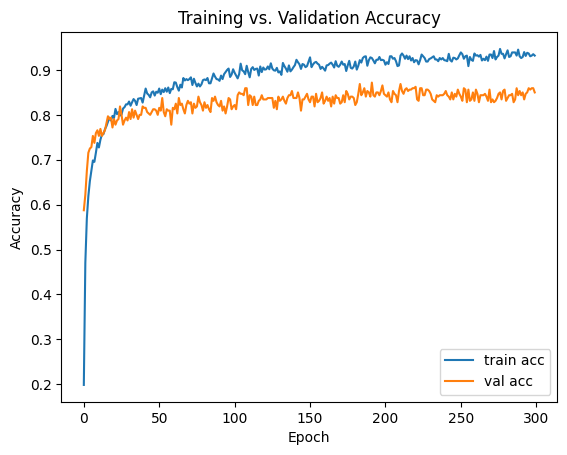

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


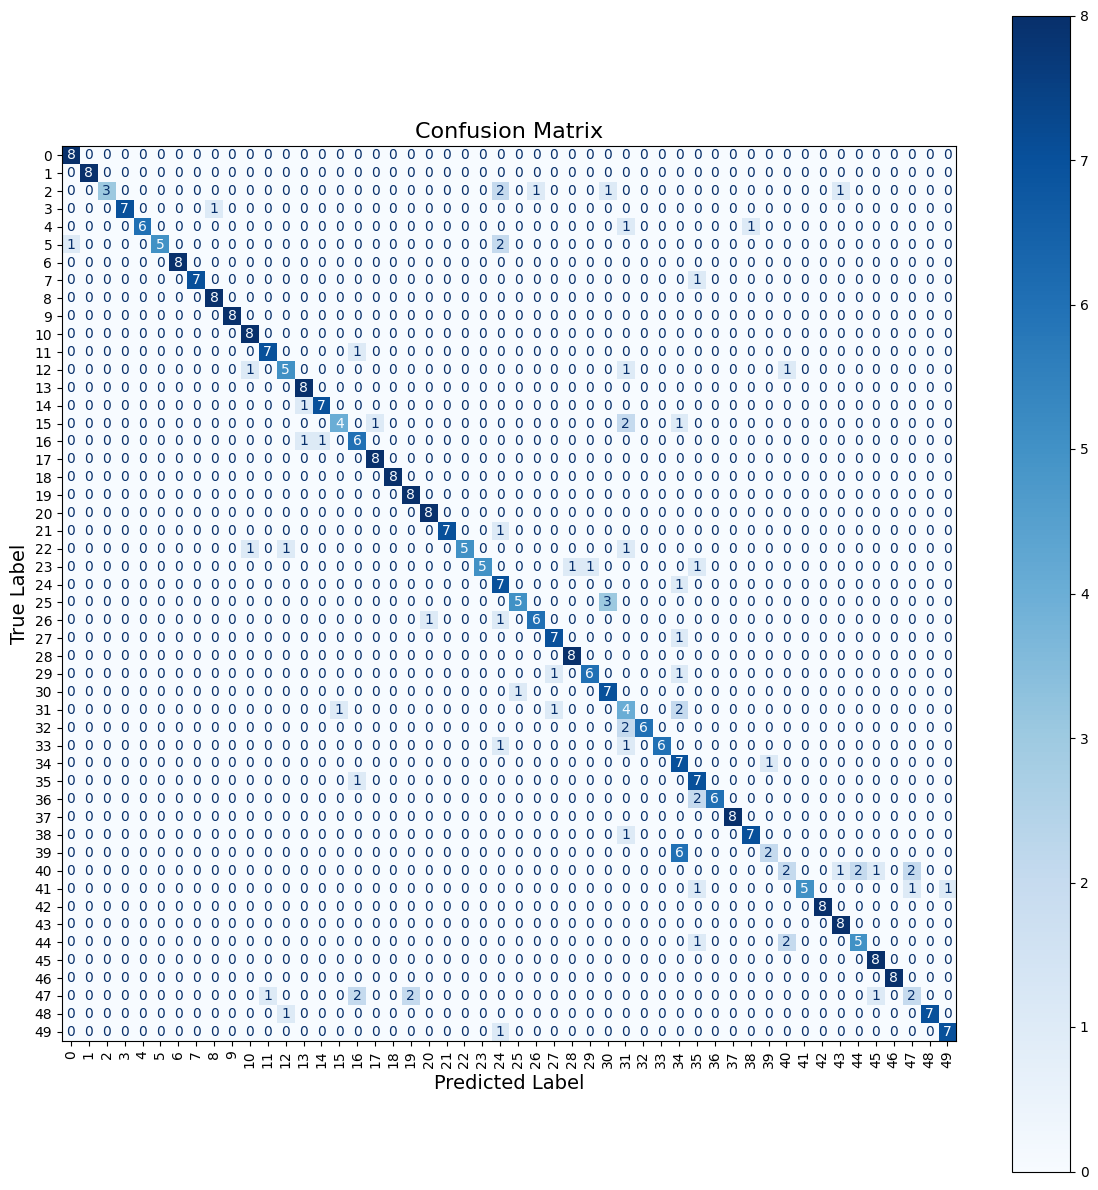

              precision    recall  f1-score   support

           0      0.889     1.000     0.941         8
           1      1.000     1.000     1.000         8
           2      1.000     0.375     0.545         8
           3      1.000     0.875     0.933         8
           4      1.000     0.750     0.857         8
           5      1.000     0.625     0.769         8
           6      1.000     1.000     1.000         8
           7      1.000     0.875     0.933         8
           8      0.889     1.000     0.941         8
           9      1.000     1.000     1.000         8
          10      0.800     1.000     0.889         8
          11      0.875     0.875     0.875         8
          12      0.714     0.625     0.667         8
          13      0.800     1.000     0.889         8
          14      0.875     0.875     0.875         8
          15      0.800     0.500     0.615         8
          16      0.600     0.750     0.667         8
          17      0.889    

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.show()


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

fig, ax = plt.subplots(figsize=(12, 12))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.tight_layout()
plt.show()

report = classification_report(y_test, y_pred, digits=3)
print(report)

In [16]:
model.save("/content/audio-classifier.keras")